In [ ]:
from multiinstance.data.gaussian_dg import GaussianMixtureDataGenerator

import matplotlib.pyplot as plt

from dist_curve.transforms import getOptimalTransform

from sklearn.metrics import roc_auc_score

from tqdm.notebook import tqdm,trange

import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
from multiinstance.nnpu import getPosterior

In [ ]:
from easydict import EasyDict

In [ ]:
dg = GaussianMixtureDataGenerator(100,1,[0.8,.9],1000,10000)

In [ ]:
[xPU,yPU,yPN] = dg.pu_data()

In [ ]:
xPUTrain,xPUVal,yPUTrain,yPUVal,yPNTrain,yPNVal = train_test_split(xPU,yPU,yPN)

In [ ]:
def build_model(input_shape):
    layers = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1024,activation="relu"),
        tf.keras.layers.Dense(1024,activation="relu"),
        tf.keras.layers.Dense(1024,activation="relu"),
        tf.keras.layers.Dense(1)
    ],name="dense_layers")
    inp1 = tf.keras.layers.Input(shape=(input_shape,),name="input_1")
    inp2 = tf.keras.layers.Input(shape=(input_shape,),name="input_2")
    score_1 = layers(inp1)
    score_2 = layers(inp2)
    score_diff = tf.keras.layers.Subtract()([score_1, score_2])
    prob = tf.keras.layers.Activation("sigmoid")(score_diff)
    model = tf.keras.models.Model(inputs=[inp1,inp2],outputs=prob)
    return model, tf.keras.backend.function([inp1],[score_1])

In [ ]:
model,ranker = build_model(xPU.shape[1])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_layers (Sequential)       (None, 1)            2203649     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 1)            0           dense_layers[0][0]           

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.BinaryCrossentropy())

In [ ]:
NIters = 5000
batch_size = 128
for iters in trange(NIters):
    idxs1 = np.random.randint(0,high=xPUTrain.shape[0],size=batch_size)
    idxs2 = np.random.randint(0,high=xPUTrain.shape[0],size=batch_size)
    inp1,inp2 = xPUTrain[idxs1],xPUTrain[idxs2]
    y1,y2 = yPUTrain[idxs1],yPUTrain[idxs2]
    target = y1 > y2
    trainLoss = model.train_on_batch([inp1,inp2],target)
#     print(trainLoss)
    if not iters % 100:
        i1 = np.random.choice(range(xPUVal.shape[0]),replace=False,
                               size=int(xPUVal.shape[0] / 2))
        i2 = list(set(range(xPUVal.shape[0])) - set(i1))
        inp1,inp2 = xPUVal[i1],xPUVal[i2]
        y1,y2 = yPUVal[i1],yPUVal[i2]
        target =y1 > y2
        valLoss = model.evaluate([inp1,inp2],target)
        print(valLoss,roc_auc_score(yPUVal,ranker(xPUVal)[0]))

43/43 [==============================] - 0s 3ms/step - loss: 0.7066
0.706626296043396 0.5589649393221613
43/43 [==============================] - 0s 4ms/step - loss: 0.7006
0.7005594968795776 0.5730095649875822
43/43 [==============================] - 0s 4ms/step - loss: 0.7063
0.7063050866127014 0.5650893547449857
43/43 [==============================] - 0s 4ms/step - loss: 0.7170
0.7169927954673767 0.6056588876249381
43/43 [==============================] - 0s 4ms/step - loss: 0.7224
0.7223901152610779 0.5788795487860328
43/43 [==============================] - 0s 4ms/step - loss: 0.7046
0.7046200037002563 0.5808000971764655
43/43 [==============================] - 0s 4ms/step - loss: 0.7096
0.709624171257019 0.5839419173638913
43/43 [==============================] - 0s 4ms/step - loss: 0.7002
0.7001911401748657 0.5959527315286743
43/43 [==============================] - 0s 4ms/step - loss: 0.7163
0.7163138389587402 0.5535168195718655
43/43 [==============================] - 0s 4ms/

In [ ]:
roc_auc_score(yPUVal,ranker(xPUVal)[0]),roc_auc_score(yPUVal, dg.pu_posterior(xPUVal))

(0.5473464423072187, 0.7366337218750462)

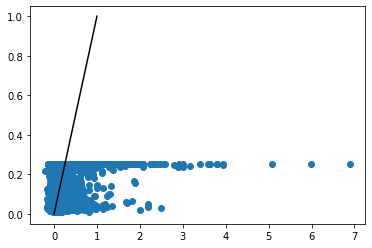

In [ ]:
plt.scatter(ranker(xPUVal)[0],dg.pu_posterior(xPUVal))
plt.plot([0,1],[0,1],color="black")

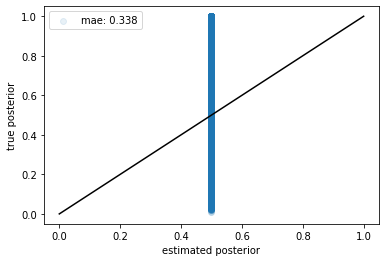

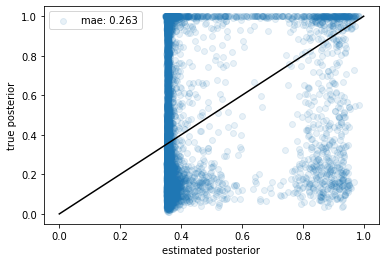

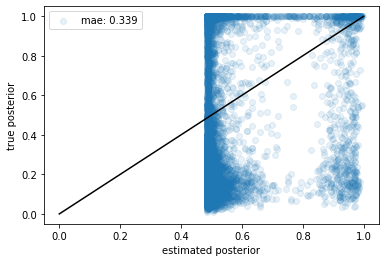

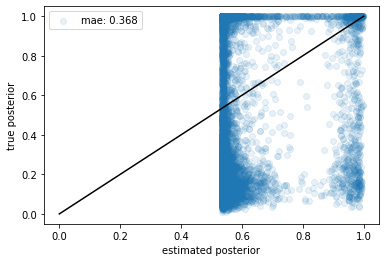

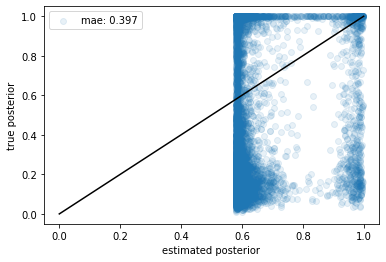

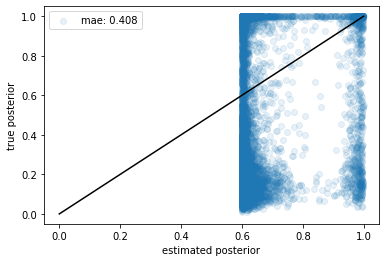

(array([[0.9918814 ],
        [0.628331  ],
        [0.95775425],
        ...,
        [0.60101247],
        [0.75800014],
        [0.60816354]], dtype=float32),
 <multiinstance.nnpu.Basic at 0x7f409aecc950>)

In [ ]:
getPosterior(xPU,yPU,dg.alpha,pupost=lambda x: ranker(x[:])[0],
             distributions=EasyDict({"true_posterior" : dg.pn_posterior_cc,
                                     "f1" : dg.dens_pos,
                                     "f0" : dg.dens_neg}),
             viz_freq=50,
             absLoss=True,
             yPN=yPN,
             training_args=EasyDict({"n_units": 128,
                                     "n_hidden":10,
                                     "dropout_rate":0.15,
                                     "maxIter":5000,
                                     "batch_size":128}),)

# Compare to the univariate transform score

In [ ]:
scores,aucpu = getOptimalTransform(xPU,yPU.ravel())

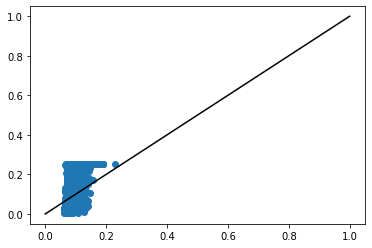

In [ ]:
plt.scatter(scores,dg.pu_posterior(xPU))
plt.plot([0,1],[0,1],color="black")

In [ ]:
roc_auc_score(yPU,scores)

0.6099981000000001

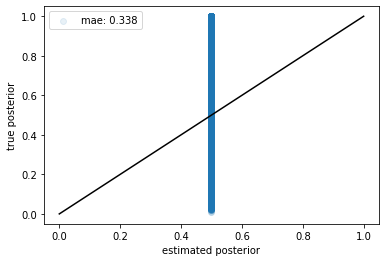

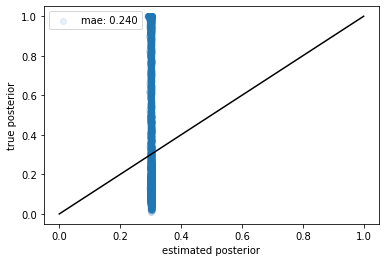

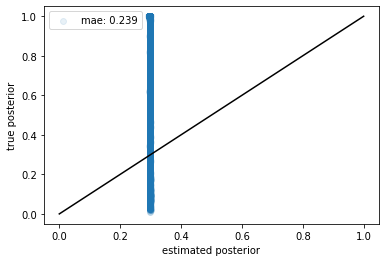

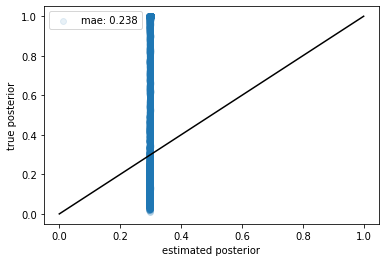

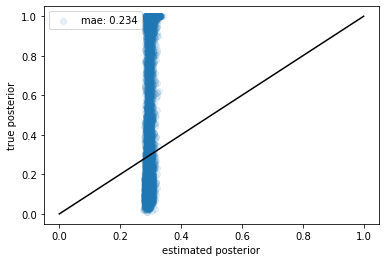

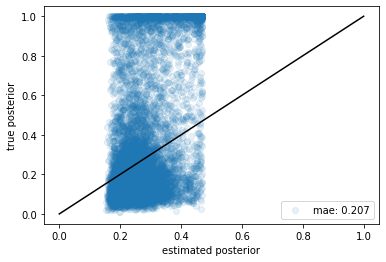

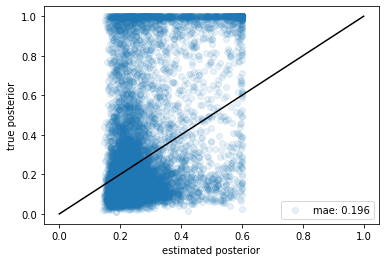

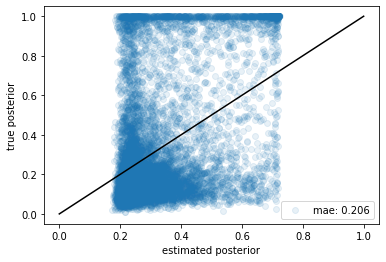

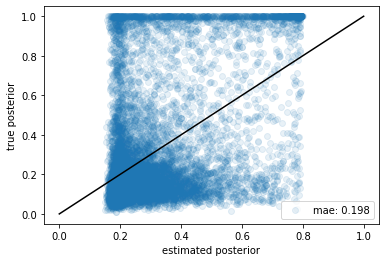

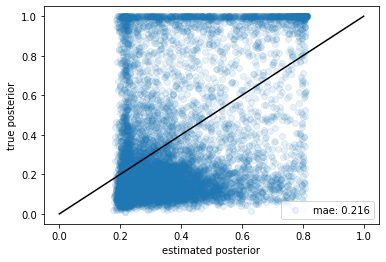

(array([[0.66276264],
        [0.3847835 ],
        [0.2166478 ],
        ...,
        [0.5375592 ],
        [0.29142842],
        [0.30379596]], dtype=float32),
 <multiinstance.nnpu.Basic at 0x7f409abd7090>)

In [ ]:
getPosterior(xPU,yPU,dg.alpha,inputs=scores[:,None],
             distributions=EasyDict({"true_posterior" : dg.pn_posterior_cc,
                                     "f1" : dg.dens_pos,
                                     "f0" : dg.dens_neg}),
             viz_freq=50,
             absLoss=True,
             yPN=yPN,
             training_args=EasyDict({"n_units": 128,
                                     "n_hidden":10,
                                     "dropout_rate":0.15,
                                     "maxIter":5000,
                                     "batch_size":128}),)